In [1]:
import numpy
import torch
from tqdm import tqdm as tqdm

# modelcomp
from modelcomp.optimisation.bayesopt import evaluate_summ, train_GP_scipy
from modelcomp.optimisation.models import ExactGP_Matern
from modelcomp.simulators.bandits import BanditDatasetPE_Multiple, sim_bandit_prior
from modelcomp.utils.utils_bo import extract_evals_custom, maximise_gp_mean, plot_slices

# GPyTorch / BoTorch
from gpytorch.likelihoods import GaussianLikelihood

# Ax
from ax import optimize
from ax import SimpleExperiment
from ax.modelbridge import get_sobol
from ax.modelbridge.factory import get_botorch
from ax.core.search_space import SearchSpace
from ax.service.utils.instantiation import parameter_from_json
from ax.modelbridge.dispatch_utils import choose_generation_strategy
from ax.storage.json_store.encoder import object_to_json
from ax.service.utils.best_point import get_best_raw_objective_point

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')
plt.rcParams['figure.figsize'] = (16.0, 8.0)
plt.rcParams.update({'font.size': 16})

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
import matplotlib.gridspec as gridspec

In [3]:
device = torch.device('cpu')

# Introduction

In this tutorial notebook we tackle the problem of finding optimal experimental designs for the Auto-regressive $\varepsilon$-Greedy (AEG) implicit model, with the aim of estimating its model parameters as accurately as possible. For brevity's sake, and to save compute resources, we here consider a simplified example where the multi-armed bandit setting consists of only $15$ trials and $1$ experimental block. This is different to the tutorial paper, where we considered $30$ trials and $3$ experimental blocks for the parameter estimation (PE) task of the AEG implicit model. However, we still consider the problem of having $3$ bandit arms.

This means that our data will be $30$-dimensional ($15$ actions plus $15$ binary rewards) and the design vector will be $3$-dimensional (one for each bandit arm).

In this tutorial notebook we show 1) how to estimate the mutual information at a single design point by training a neural network and then 2) how to maximize the mutual information via Bayesian optimization in order to find optimal designs.

# Estimate mutual information for a single design point

## Simulate prior samples

We first specify the problem by saying which model we care about, how many bandit arms, trials and experimental blocks we consider, and how many data points we want to sample from the data-generating process during training.

In [25]:
# specify which implicit model we consider (WSLTS: 0, AEG: 1, GLS: 2)
SIMMODEL = 1

# specify hyper-parameters of the data-generating process
NUM_ARMS = 3  # number of arms
NUM_TRIALS = 15  # number of trials
NUM_BLOCKS = 1  # number of experimental blocks
DATASIZE = 20000  # number of data points to generate at each design (this is much more than necessary)

We then sample model parameters from the (uninformative) prior distribution, i.e. `U(0, 1)`, using the `sim_bandit_prior` method:

In [26]:
# sample from the prior distribution
prior_samples = sim_bandit_prior(DATASIZE, prior='uninformed', simmodel=SIMMODEL)

Note that the shape of the resulting numpy array is `(DATASIZE, 12)`, but for the AEG model only the elements `prior_samples[:, 4:6]` matter, since `prior_samples[:, 0]` corresponds to the model indicator (which is 1 throughout for the AEG model), and the other columns will be 0 throughout, since they correspond to the model parameters of the other implicit models (WSLTS and GLS).

## Train a neural network at a (random) baseline design point

In order to estimate the mutual information at a single design point, we need to train a neural network on the prior samples generated above and synthetic data generated using those prior samples. As a loss function, we will be using a lower bound on the mutual information, which is tightened as the training progresses. 

All of these details are conveniently taken care of within the `modelcomp` package and, therefore, we will only be showing the high-level API here.

We first need to specify some hyper-parameters needed in the neural network training, as done below. There are a couple of critical hyper-parameters that should be fine-tuned depending on the problem. These are the general neural network hyper-parameters, such as `batchsize`, `layers`, `hidden`, `lr`, and then, crucially, the summary statistics network hyper-parameters, i.e. `summ_L`, `summ_H` and `summ_out`.

In [27]:
hyperparams = {
    # general neural network hyper-parameters
    'batchsize': 1024,  # batch-size for each training epoch
    'layers': 2,  # number of hidden layers for critic
    'hidden': [64, 32],  # number of hidden units for critic
    'lr': 1e-3,  # learning rate
    'weight_decay': 1e-3,  # weight-decay of Adam optimizer
    'num_epochs': 200, # number of training epochs
    'num_workers': 0,
    # summary statistics hyper-parameters
    'num_measurements': NUM_BLOCKS,  # the number of experimental blocks
    'summary_stats': True,  # wheter to use the summary statisticcs heads
    'summ_L': 2,  # number of hidden layers for each summ head
    'summ_H': [64, 32],  # number of hidden units for each summ head
    'summ_out': 6,  # output dimensions of summary stats
    # lr scheduler hyper-parameters
    'scheduler': 'plateau',
    'plateau_factor': 0.5,
    'plateau_patience': 25
}

For the purpose of showcasing an example training procedure, we here use a random baseline design point, which is sampled from a $\beta(2, 2)$ distribution:

In [86]:
# set the numpy random seed generator
rng = numpy.random.default_rng(42)

# sample a random design from a beta(2, 2) distribution
design_base = rng.beta(2, 2, size=(NUM_BLOCKS, NUM_ARMS))

print('Random baseline design:', design_base)

Random baseline design: [[0.42454803 0.52758894 0.63718018]]


We then perform the training procedure, thereby estimating the mutual information at the above baseline design, by means of the `evaluate_summ` method:

In [87]:
training_results = evaluate_summ(
    design_base,
    prior_samples,
    device,
    hyperparams,
    BanditDatasetPE_Multiple, 
    simbar=False,
    bar=True,
    num_trials=NUM_TRIALS,
    num_blocks=NUM_BLOCKS,
    num_arms=NUM_ARMS,
    valid=True,
    simmodel=SIMMODEL
)

 78%|███████▊  | 156/200 [00:28<00:10,  4.22it/s, Train Loss=0.493, Valid Loss=0.415]

Epoch   156: reducing learning rate of group 0 to 5.0000e-04.


 93%|█████████▎| 186/200 [00:35<00:03,  4.12it/s, Train Loss=0.570, Valid Loss=0.412]

Epoch   186: reducing learning rate of group 0 to 2.5000e-04.


100%|██████████| 200/200 [00:38<00:00,  5.14it/s, Train Loss=0.601, Valid Loss=0.453]


Let us access some of the training results and store them with more useful variable names:

In [88]:
vscore = training_results[0]  # the final validation score, i.e. the estimate of mutual information at the design
tloss = training_results[1]  # the full trace of the training loss, for each batch
vloss = training_results[2]  # the full trace of the validation loss 
model_trained = training_results[3]  # the trainined main neural network
model_summ_trained = training_results[4]  # the trained summary statistics neural network

In [89]:
print('Final mutual information estimate at the baseline design:', vscore)

Final mutual information estimate at the baseline design: 0.4775815


We can also plot the training and validation loss to examine how well the training procedure went, as shown below.

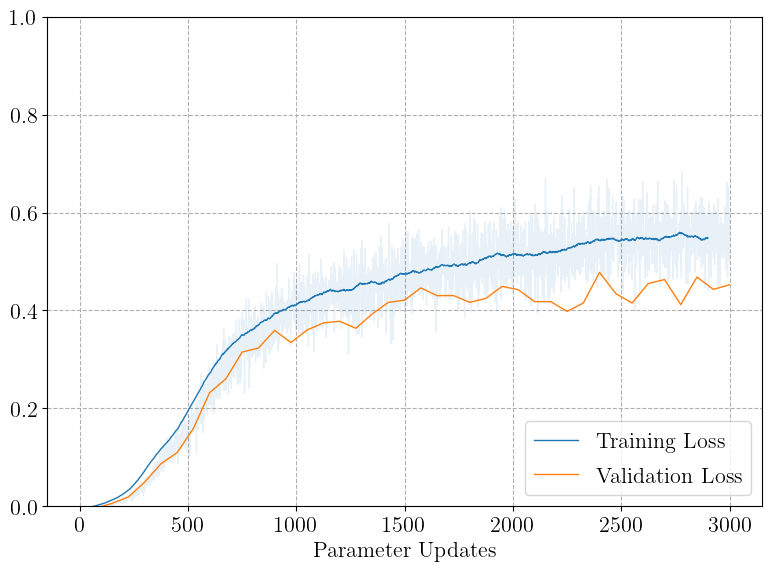

In [90]:
def ma(a, ws=100):
    """Moving average to smoothen out the training loss."""
    return [numpy.mean(a[i:i + ws]) for i in range(0,len(a) - ws)]

# align the training and validation losses
upd = int(len(tloss) / len(vloss))
mal = ma(tloss, ws=100)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)


ax.plot(range(1, len(tloss)+1), tloss, lw=1, alpha=0.1, c=cycle[0])
ax.plot(range(1, len(mal)+1), mal, lw=1, alpha=1, c=cycle[0], label='Training Loss')
ax.plot(range(upd, len(tloss) + upd, upd), vloss, lw=1, alpha=1, c=cycle[1], label='Validation Loss')

ax.set_ylim([0, 1])
ax.set_xlabel('Parameter Updates')
ax.grid(True, ls='--')
ax.legend(loc='lower right', ncol=1)

plt.tight_layout();

# Maximize mutual information via Bayesian optimization

Next, we consider how to maximize the mutual information by means of Bayesian optimization (BO). To do so, we need to estimate the MI for several experimental designs, as done above. These designs are no longer random, however, but are instead suggested by BO, with the aim of reaching the maximum mutual information as soon as possible.

We will be heavily relying on the following packages: `GPyTorch`, `Ax` and `BoTorch`. Please see their documentation to learn more about the individual functions that will be used here.

## Helper functions

We first define a few helper functions that take care of training a neural network and fitting a Gaussian process (GP) surrogate model.

In [28]:
# we shall re-use the hyper-parameters specified and prior samples sampled above
HYPERPARAMS = hyperparams
PRIOR_SAMPLES = prior_samples


def objective_designs(parameters):
    
    # extract designs
    d = numpy.array(
        [parameters.get("d{}".format(i)) for i in range(1, len(parameters) + 1)]
    ).reshape(-1, 1)

    # get validation score
    val, _, _, _, _ = evaluate_summ(
        d,
        PRIOR_SAMPLES,
        device,
        HYPERPARAMS,
        BanditDatasetPE_Multiple, 
        simbar=False,
        bar=False,
        num_trials=NUM_TRIALS,
        num_blocks=NUM_BLOCKS,
        num_arms=NUM_ARMS,
        valid=True,
        simmodel=SIMMODEL
    )

    return val


def get_and_fit_model(Xs, Ys, **kwargs):
    
    train_x, train_y = Xs[0], Ys[0]

    # Create GP Model
    likelihood = GaussianLikelihood(noise_prior=None)
    model = ExactGP_Matern(
        train_x, train_y, likelihood, 
        lengthscale_prior=None, outputscale_prior=None)
        
    # Fit GP Model using Scipy
    model, _ = train_GP_scipy(
        model, likelihood, train_x, train_y, 
        lr=0.001, train_iter=1000)
        
    return model

## Run Bayesian optimization

We will then maximize the mutual information by following a regular `BoTorch` Bayesian optimization routine.

First, we will specify the parameter search space:

In [113]:
# total number of designs
num_designs = NUM_ARMS * NUM_BLOCKS

# Create the design search space
parameters = [{"name": "d{}".format(i), 
            "type": "range", "bounds": [0.0, 1.0], 
            "value_type": "float"} for i in range(1, num_designs+1)]
exp_parameters = [parameter_from_json(p) for p in parameters]
space = SearchSpace(parameters=exp_parameters, parameter_constraints=None)

We then create the experiment, which involves instantiating a class that manages the state of the BO experiment. In doing so, we also specify that the objective function to maximize is given by the previously defined `objective_designs`.

In [114]:
# Create the experiment
exp = SimpleExperiment(
    name=f"Bandit_BO_{NUM_ARMS}arms",
    search_space=space,
    evaluation_function=objective_designs,
    objective_name="lower_bound",
    minimize=False,
)

Finally, we perform our BO routine, consisting of the following steps:
1. Initializing a few design points that are generated from a Sobol sequence (rather than uniform at random).
2. Run BO, which involves these sub-steps:
    1. Estimating the mutual information (as above) for a single design point,
    2. Fitting a Gaussian Process to all mutual information evaluations,
    3. Maximizing the Expected Improvement (EI) acquisition function, thereby suggesting the next design point to evaluate.
3. Run the BoTorch method one last time to obtain a properly fitted Gaussian Process.

In [115]:
INIT_EVALS = 5  # the number of initial design points
MAX_EVALS = 20  # the maximum number of evaluations in BO, including the initial ones

In [118]:
# Initial BO Evaluations
print(f"Starting {INIT_EVALS} Initial Sobol Evaluations")
sobol = get_sobol(exp.search_space)
for i in tqdm(range(INIT_EVALS)):

    exp.new_trial(generator_run=sobol.gen(1))

# Sequential BO Evaluations
print(f"Starting {MAX_EVALS - INIT_EVALS} BO Evaluations")
for i in tqdm(range(MAX_EVALS - INIT_EVALS)):
    
    model = get_botorch(
        experiment=exp,
        data=exp.eval(),
        search_space=exp.search_space,
        model_constructor=get_and_fit_model
    )
    batch = exp.new_trial(generator_run=model.gen(1))
    
# Run it one more time to get the last GP fit
model = get_botorch(
        experiment=exp,
        data=exp.eval(),
        search_space=exp.search_space,
        model_constructor=get_and_fit_model
)
batch = exp.new_trial(generator_run=model.gen(1))
print("Done!")

  0%|          | 0/15 [00:00<?, ?it/s]

Starting 5 Initial Sobol Evaluations
Starting 15 BO Evaluations


 47%|████▋     | 7/15 [08:44<09:17, 69.73s/it] /Users/steven/anaconda3/envs/modelcomp/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:46: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

100%|██████████| 15/15 [15:01<00:00, 60.12s/it]


Done!


## Save Bayesian optimization results

In order to save and analyze the BO results more effectively, we first serialize the experiment object into a JSON object. The results can then be saved as a dictionary in various ways, e.g. via the in-built `torch.save` function.

In [126]:
# convert experiment data to json
json_experiment = object_to_json(exp)

# get best evaluation
best_parameters, all_values = get_best_raw_objective_point(exp)
values = (
    {k: v[0] for k, v in all_values.items()},  # v[0] is mean
    {k: {k: v[1] * v[1]} for k, v in all_values.items()},  # v[1] is sem
)

In [128]:
# Prepare data to save
bo_dict = {
    'best_parameters': best_parameters,
    'values': values,
    'json_experiment': json_experiment}

# Add arguments to parser
save_dict = dict(**bo_dict, hyperparams=hyperparams, init_evals=INIT_EVALS, max_evals=MAX_EVALS)

In [130]:
# specify where to save the BO results
filename = 'bo_pe_aeg_test'
directory = '../data/'

# save results
torch.save(save_dict, directory + '{}.pt'.format(filename))

## Analyze the Bayesian optimization results

We can start analyzing the Bayesian optimization results by either loading in saved results, or by simply using the results computed above, e.g.

In [4]:
# load in data from previous BO run
data = torch.load('../data/bo_pe_aeg_test.pt')

Let us first find out the maximum mutual information evaluation and the corresponding experimental design. Note that this does not necessarily need to correspond to the optimal design just yet, but rather corresponds to the best (noisy) evaluation.

In [42]:
mi_max = data['values'][0]['lower_bound']
design_max = list(data['best_parameters'].values())

print('Maximum MI evaluation:', mi_max)
print('Corresponding designs:', design_max)

Maximum MI evaluation: 0.7937107682228088
Corresponding designs: [0.0, 1.0, 0.0]


We then extract useful data out of the serialized JSON experiment with the `extract_custom_vals` helper function, i.e.

In [6]:
# extract evaluations from data object
X, Y = extract_evals_custom(data)

# convert data to torch tensors for later
train_x = torch.tensor(X)
train_y = torch.tensor(Y)

Finally, let us visualize the performance of the Bayesian optimization procedure by looking at two plots: 1) how far away the design suggested by BO is from the currently-best design, which quantifies how much exploration we do, and 2) the currently-best design as a function of mutual information evaluations. These plots should provide guidance on how much exploration we are doing and how quickly we are converging to the local optimum.

In [8]:
# find out the currently-best design as a function of evaluations
best_val = list()
for y in Y:
    if len(best_val) == 0:
        best_val.append(y)
    elif max(best_val) > y:
        best_val.append(best_val[-1])
    else:
        best_val.append(y)
best_val = numpy.array(best_val)
        
# distance of suggested design to currently-best design as a function of evaluations
dist_to_opt = (best_val - Y)**2

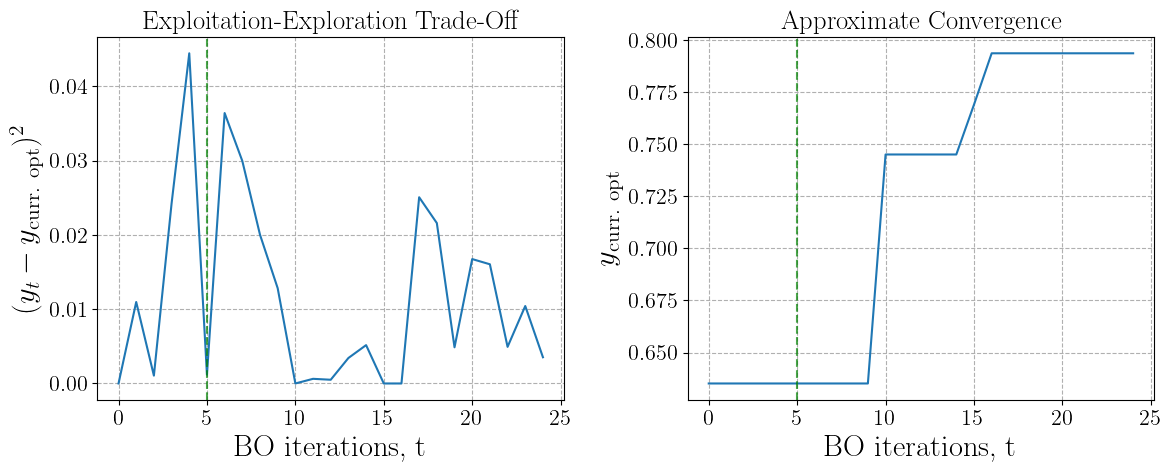

In [9]:
init_evals = data['init_evals']
    
fig = plt.figure(figsize=(12, 5))

ax = fig.add_subplot(121)
ax.plot(range(0, len(Y)), dist_to_opt)
ax.set_xlabel('BO iterations, t', size=22)
ax.set_ylabel(r'$(y_t - y_{\text{curr. opt}})^2$', size=22)
ax.set_title('Exploitation-Exploration Trade-Off')
ax.axvline(init_evals, ls='--', c='g', alpha=0.7)
ax.grid(True, ls='--')

ax = fig.add_subplot(122)
ax.plot(range(0, len(Y)), best_val)
ax.set_xlabel('BO iterations, t', size=22)
ax.set_ylabel(r'$y_{\text{curr. opt}}$', size=22)
ax.set_title('Approximate Convergence')
ax.axvline(init_evals, ls='--', c='g', alpha=0.7)
ax.grid(True, ls='--')

plt.tight_layout();

Note that the green line signifies the initial design points that were generated from a Sobol sequence and not suggested by BO.

## Plot the mutual information as a function of design values

Perhaps we'd also like to visualize the Gaussian Process (GP) surrogate model of our mutual information estimates. In order to do this, we first need to re-fit a GP to the BO data, which we can do via the `get_and_fit_model` defined above that uses the `train_GP_scipy` method under the hood, i.e.

In [18]:
x_reshaped = train_x.reshape([1, *train_x.shape])
y_reshaped = train_y.reshape([1, *train_y.shape])

In [29]:
# get and fit a GP
gp_trained = get_and_fit_model(x_reshaped, y_reshaped)

Let us then visualize the GP posterior predictive mean (i.e. a fit to the mutual information evaluations), and its standard deviation, using the `plot_slices` helper function. We can, unfortunately, only plot slices, since we cannot easily visualize three-dimensional design spaces.

This can be done by passing a slice dictionary to `plot_slices`, which has `None` for those designs that we would like to look at, and fixed values for _all but two_ entries. This is shown below:

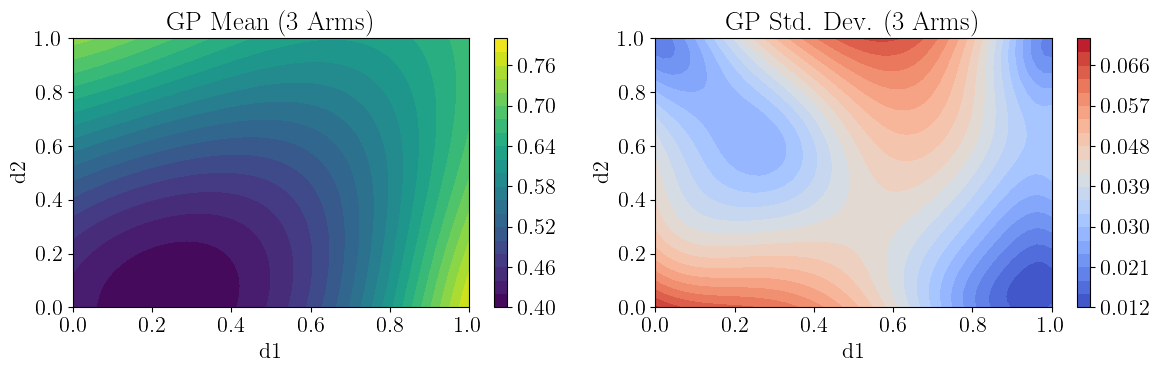

In [41]:
# specify the slice dictionary
slice_dict = {'d1': None, 'd2': None, 'd3': 0}
fig, ax = plot_slices(gp_trained, slice_dict, std=True)

## Maximize GP posterior mean to get local optima

Lastly, we need to maximize the previously-shown GP posterior mean with respect to experimental designs, which allows us to obtain a set of local optimal (and their respective mutual information estimates). This can be done easily using the `maximize_gp_mean`, which uses SGD to maximize the GP posterior mean with several restarts.

In [44]:
# maximize GP with several restarts
d_opt, local_optima, local_GP_maxima = maximise_gp_mean(
    gp_trained, arms=3, blocks=1, lr=1e-3, max_iter=2000, num_restarts=20
)

100%|██████████| 20/20 [01:16<00:00,  3.83s/it]


The local optima found by maximizing the GP posterior mean are thus:

In [45]:
for i in range(len(local_optima)):
    print('GP val: {:.4f} --- Design:'.format(local_GP_maxima[i]), local_optima[i].reshape(-1, 3).tolist())

GP val: 0.7803 --- Design: [[0.0, 1.0, 0.0]]
GP val: 0.7803 --- Design: [[0.0, 1.0, 0.0]]
GP val: 0.7803 --- Design: [[0.0, 1.0, 0.0]]
GP val: 0.7803 --- Design: [[0.0, 1.0, 0.0]]
GP val: 0.7803 --- Design: [[0.0, 1.0, 0.0]]
GP val: 0.7286 --- Design: [[1.0, 0.0, 0.0]]
GP val: 0.7286 --- Design: [[1.0, 0.0, 0.0]]
GP val: 0.7286 --- Design: [[1.0, 0.0, 0.0]]
GP val: 0.7286 --- Design: [[1.0, 0.0, 0.0]]
GP val: 0.7280 --- Design: [[0.0, 0.061227425932884216, 1.0]]
GP val: 0.7280 --- Design: [[0.0, 0.06122738867998123, 1.0]]
GP val: 0.7280 --- Design: [[0.0, 0.06122737005352974, 1.0]]
GP val: 0.7194 --- Design: [[0.0, 1.0, 1.0]]
GP val: 0.7194 --- Design: [[0.0, 1.0, 1.0]]
GP val: 0.7154 --- Design: [[1.0, 0.0, 1.0]]
GP val: 0.7154 --- Design: [[1.0, 0.0, 1.0]]
GP val: 0.7154 --- Design: [[1.0, 0.0, 1.0]]
GP val: 0.7154 --- Design: [[1.0, 0.0, 1.0]]
GP val: 0.7154 --- Design: [[1.0, 0.0, 1.0]]
GP val: 0.7154 --- Design: [[1.0, 0.0, 1.0]]


This tells us that the optimal design should be at `[0, 1, 0]`, resulting in a mutual information estimate of `0.78`.